In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Define a transform to convert images to tensors
# Transform to -1, 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomRotation(10),
])

# 2. Download and load the training data
ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 4. Use a DataLoader to iterate through the data in batches
loader = DataLoader(ds, batch_size=256, shuffle=True, drop_last=True)

In [2]:
# Create model
class DownsampleBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.downsample = nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=0
        )
        self.expand_block = nn.Sequential(
            nn.GroupNorm(1, channels),
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels * 2,
                kernel_size=3,
                stride=1,
                padding=1
            ), # Expand it up
            nn.SiLU(),
            # Few depth wise convs
            nn.Conv2d(
                in_channels=channels * 2,
                out_channels=channels * 2,
                kernel_size=3,
                stride=1,
                padding=1,
                groups=channels * 2
            ),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=channels * 2,
                out_channels=channels * 2,
                kernel_size=3,
                stride=1,
                padding=1,
                groups=channels * 2
            ),
            nn.SiLU()
        )
    
    def forward(self, x):
        # x: (B, channels, H, W)
        x = self.downsample(x)
        return self.expand_block(x)

class UpsampleResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels=channels,
            out_channels=channels // 2,
            kernel_size=2,
            stride=2,
            padding=0
        )
        
        # Note here we will get another concat channel so we have channels
        self.concat_block = nn.Sequential(
            nn.GroupNorm(1, channels),
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels // 2,
                kernel_size=3,
                stride=1,
                padding=1
            ), 
            nn.SiLU(),
            # Few depth wise convs
            nn.Conv2d(
                in_channels=channels // 2,
                out_channels=channels // 2,
                kernel_size=3,
                stride=1,
                padding=1,
                groups=channels // 2
            ),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=channels // 2,
                out_channels=channels // 2,
                kernel_size=3,
                stride=1,
                padding=1,
                groups=channels // 2
            ),
            nn.SiLU(),
        )
    def forward(self, x, res_channel):
        x = self.upsample(x) # (B, channels // 2, H*2, W*2)
        # Concat res channel
        x = torch.cat([x, res_channel], dim=1) # (B, channels, H*2, W*2)
        return self.concat_block(x)

class Diffusion(nn.Module):
    def __init__(self, in_channels, latent_channels, num_classes):
        """
        Model will expand from in_channels x H x W to latent_dim x H x W
        Inputs here are meant for 28x28
        """
        super().__init__()
        self.latent_channels = latent_channels
        
        self.class_dict = nn.Embedding(num_classes, latent_channels*2) # Add a tunable gamma and beta to edit each latent_dim to embed class information
        self.time_fn = nn.Sequential(
            nn.Linear(1, latent_channels * 2),
            nn.SiLU(),
            nn.Linear(latent_channels * 2, latent_channels * 2), # Predict sin waves, so each value is a coefficient used in sin(kT)
        )
        self.time_editor = nn.Linear(latent_channels * 2, latent_channels * 2) # Used AFTER sin to project values properly
        
        self.latent_expansion = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=latent_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.SiLU(),
            
            # Few depth wise conv
            nn.Conv2d(
                in_channels=latent_channels,
                out_channels=latent_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                groups=latent_channels
            ),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=latent_channels,
                out_channels=latent_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                groups=latent_channels
            ),
            nn.SiLU(),
        ) # (LC, 32, 32) 
        
        self.block1 = DownsampleBlock(latent_channels) # (LC * 2, 16, 16)
        self.block2 = DownsampleBlock(latent_channels * 2) # (LC * 4, 8, 8)
        self.block3 = DownsampleBlock(latent_channels * 4) # (LC * 8, 4, 4)
        self.block4 = DownsampleBlock(latent_channels * 8) # (LC * 16, 2, 2)
        
        self.block5_3 = UpsampleResBlock(latent_channels * 16) # 4_3 means 3 is the residual to 4
        self.block6_2 = UpsampleResBlock(latent_channels * 8) # Note block4 is not used (cant residue yourself)
        self.block7_1 = UpsampleResBlock(latent_channels * 4) # (LC * 2, 32, 32)
        
        # This block uses our latent expansion
        self.block8_latents = UpsampleResBlock(latent_channels * 2) # (LC, 32, 32)
        
        # Get x back to in_channels
        self.output_head = nn.Sequential(
            nn.Conv2d(
                in_channels=latent_channels,
                out_channels=in_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        )
    
    def forward(self, x, target_class, t):
        # x: (B, C, 28, 28)
        # target_class: (B,)
        # t (B,)
        t = t.unsqueeze(1)
        B = target_class.shape[0]
        
        class_modifier = self.class_dict(target_class) # (B, LC * 2)
        time_modifier = self.time_editor(torch.sin(self.time_fn(t) * t))
        modifier = class_modifier + time_modifier
        x = self.latent_expansion(x) # (B, LC, 32, 32)
        
        # Get gamma and beta
        modifier = modifier.view(B, self.latent_channels, 2)
        gamma, beta = torch.unbind(modifier, dim=-1) # (B, LC) each
        gamma = gamma.view(B, self.latent_channels, 1, 1)
        beta = beta.view(B, self.latent_channels, 1, 1) 
        
        # Transform x
        x = (x * (1 + gamma)) + beta # (B, LC, 32, 32)
        
        # Run all blocks
        b1 = self.block1(x)
        b2 = self.block2(b1)
        b3 = self.block3(b2) # (B, LC * 8, 4, 4)
        b4 = self.block4(b3)
        b5 = self.block5_3(b4, b3)
        b6 = self.block6_2(b5, b2)
        b7 = self.block7_1(b6, b1)
        b8 = self.block8_latents(b7, x) # (B, LC, 32, 32)
        
        # Get output
        out = self.output_head(b8)
        
        return out

In [3]:
import copy
class EMA:
    def __init__(self, model, decay=0.9997):
        self.ema_model = copy.deepcopy(model)
        self.ema_model.eval()
        self.decay = decay
        # Stop gradients for the EMA model
        for param in self.ema_model.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def step(self, model):
        # model is the one being trained
        for ema_param, current_param in zip(self.ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(self.decay).add_(current_param.data, alpha=1 - self.decay)

In [4]:
def configure_optimizers(model, weight_decay, learning_rate):
    # 1. Create empty lists
    decay_params = []
    nodecay_params = []
    
    # 2. Iterate over named parameters
    for pn, p in model.named_parameters():
        if p.requires_grad:
            
            # CHECK 1: Dimensions
            # - Weights are usually >= 2D
            # - Biases and Norms are 1D
            is_bias_or_norm = p.dim() < 2
            
            # CHECK 2: Explicit Names to EXCLUDE from decay
            # If 'pos_embedding' is in the name, force it to no_decay
            no_decay_names = [
                'class_dict'
            ]

            # Logic: If it's big (2D+) AND NOT an embedding, decay it.
            if is_bias_or_norm or any(nd in pn for nd in no_decay_names):
                nodecay_params.append(p)
            else:
                decay_params.append(p)

    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    
    return torch.optim.AdamW(optim_groups, lr=learning_rate)

In [5]:
def gen_noise(x):
    B = x.shape[0]
    noise_ratio = torch.rand((B, 1, 1, 1), dtype=torch.float32)
    
    noise = torch.randn_like(x)
    noised_x = torch.sqrt(1 - noise_ratio) * x + torch.sqrt(noise_ratio) * noise
    
    return noised_x, noise, noise_ratio.view(-1)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
model = Diffusion(1, 64, 10).to(device)
ema_model = EMA(model)
sum(p.numel() for p in model.parameters() if p.requires_grad)

15422785

In [8]:
optim = configure_optimizers(model, 0, 1e-3)
criterion = nn.MSELoss()

In [9]:
k = 0
while True:
    for x, label in loader:
        # Now we need to add noise to x
        # x: (B, 1, 28, 28)
        noise_x, noise, noise_ratio = gen_noise(x)
        
        # Conv to device
        noise = noise.to(device)
        noise_x = noise_x.to(device)
        noise_ratio = noise_ratio.to(device)
        label = label.to(device)
        
        pred = model(noise_x, label, noise_ratio)
        loss = criterion(pred, noise)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        ema_model.step(model)
        
        k += 1
        if k % 50 == 0:
            print(f"Epoch: {k}\nLoss: {loss.item():.4f}")

Epoch: 50
Loss: 0.2935
Epoch: 100
Loss: 0.1276
Epoch: 150
Loss: 0.1068
Epoch: 200
Loss: 0.0856
Epoch: 250
Loss: 0.0892
Epoch: 300
Loss: 0.0689
Epoch: 350
Loss: 0.0678
Epoch: 400
Loss: 0.0539
Epoch: 450
Loss: 0.0683
Epoch: 500
Loss: 0.0571
Epoch: 550
Loss: 0.0660
Epoch: 600
Loss: 0.0510
Epoch: 650
Loss: 0.0523
Epoch: 700
Loss: 0.0478
Epoch: 750
Loss: 0.0498
Epoch: 800
Loss: 0.0498
Epoch: 850
Loss: 0.0461
Epoch: 900
Loss: 0.0521
Epoch: 950
Loss: 0.0484
Epoch: 1000
Loss: 0.0464
Epoch: 1050
Loss: 0.0443
Epoch: 1100
Loss: 0.0455
Epoch: 1150
Loss: 0.0510
Epoch: 1200
Loss: 0.0434
Epoch: 1250
Loss: 0.0488
Epoch: 1300
Loss: 0.0413
Epoch: 1350
Loss: 0.0414
Epoch: 1400
Loss: 0.0408
Epoch: 1450
Loss: 0.0461
Epoch: 1500
Loss: 0.0356
Epoch: 1550
Loss: 0.0434
Epoch: 1600
Loss: 0.0443
Epoch: 1650
Loss: 0.0388
Epoch: 1700
Loss: 0.0346
Epoch: 1750
Loss: 0.0409
Epoch: 1800
Loss: 0.0398
Epoch: 1850
Loss: 0.0358
Epoch: 1900
Loss: 0.0386
Epoch: 1950
Loss: 0.0359
Epoch: 2000
Loss: 0.0426
Epoch: 2050
Loss: 0.

KeyboardInterrupt: 

In [10]:
@torch.no_grad()
def sample(model, target_labels, steps=1000, device="cuda"):
    model.eval()
    B = len(target_labels)
    labels = torch.tensor(target_labels).to(device)
    
    # 1noise
    x = torch.randn((B, 1, 32, 32)).to(device)
    
    t_list = torch.linspace(1, 0, steps + 1)
    
    for i in range(steps):
        curr_t = t_list[i]
        next_t = t_list[i+1]
        
        t_batch = torch.full((B,), curr_t).to(device)
        
        # predict noise
        pred_noise = model(x, labels, t_batch)
        
        # Take steps in general direction
        sqrt_t = torch.sqrt(curr_t)
        sqrt_one_minus_t = torch.sqrt(1 - curr_t)
        
        # Avoid division by zero at the very end
        pred_x0 = (x - sqrt_t * pred_noise) / (sqrt_one_minus_t + 1e-8)
        pred_x0 = torch.clamp(pred_x0, -1, 1)
        
        # Step in state
        if next_t > 0:
            sqrt_next_t = torch.sqrt(next_t)
            sqrt_one_minus_next_t = torch.sqrt(1 - next_t)
            x = sqrt_one_minus_next_t * pred_x0 + sqrt_next_t * pred_noise
        else:
            x = pred_x0 # The final step is just the clean image
            
    model.train()
    
    # Convert back to [0, 1] for viewing
    return (x + 1) / 2

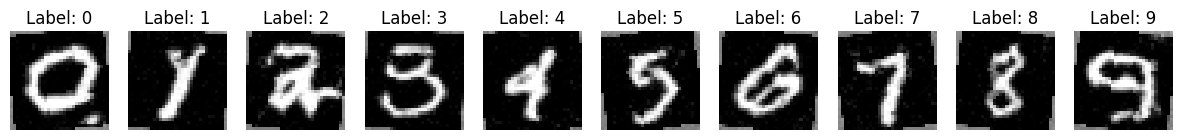

In [45]:
import matplotlib.pyplot as plt

# plot my shi
digits_to_gen = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
generated_images = sample(ema_model.ema_model, digits_to_gen, steps=8, device=device)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {i}")
    axes[i].axis('off')
plt.show()